In [1]:
#Import all the dependencies and loading the dataset
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
trainingdata=datasets.MNIST(root="data",train=True,download=True,transform=ToTensor())
testdata=datasets.MNIST(root="data",train=False,download=True,transform=ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:06<00:00, 1632214.14it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 144671.59it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 974325.28it/s] 


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [2]:
#dataloader
loader={
    "train":DataLoader(trainingdata,batch_size=500,shuffle=True),
    "test":DataLoader(testdata,batch_size=500,shuffle=True)
}

In [3]:
#network for model
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.conv1=nn.Conv2d(1,16,kernel_size=3,padding=1)
    self.bn1=nn.BatchNorm2d(16)
    self.conv2=nn.Conv2d(16,32,kernel_size=3,padding=1)
    self.fc1=nn.Linear(32*7*7,128)
    self.bn2=nn.BatchNorm1d(128)
    self.drop=nn.Dropout(0.5)
    self.fc2=nn.Linear(128,64)
    self.fc3=nn.Linear(64,10)

  def forward(self,x):
    x=f.relu(f.max_pool2d(self.conv1(x),2))
    x=self.bn1(x)
    x=f.relu(f.max_pool2d(self.conv2(x),2))
    x=x.view(-1,32*7*7)
    x=f.relu(self.fc1(x))
    x=self.bn2(x)
    x=self.drop(x)
    x=self.fc2(x)
    x=self.fc3(x)
    return x


In [9]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu") #shifting model to gpu if present
model=CNN().to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)
costs=[]
acuracies=[]
#Training Loop
for epoch in range(50):
  correct=0
  total=0
  model.train()  # Set the model to training mode
  for batch,(data,target) in enumerate(loader["train"]):
    data,target=data.to(device),target.to(device)
    optimizer.zero_grad()
    output=model(data)
    pred=output.argmax(dim=1,keepdim=True)  
    total+=target.size(0)
    correct+=pred.eq(target.view_as(pred)).sum().item() #calculating the accuracy
    acuracies.append((correct/total)*100) 
    loss=criterion(output,target)
    loss.backward()
    optimizer.step()
    costs.append(loss.cpu().detach().numpy())   # Move to CPU and convert to NumPy
  
  if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Average Loss: {loss},accuracy:{(correct/total)*100}")
   

Epoch: 0, Average Loss: 0.07753963023424149,accuracy:93.02666666666667
Epoch: 10, Average Loss: 0.01817033253610134,accuracy:99.46666666666667
Epoch: 20, Average Loss: 0.00868257973343134,accuracy:99.715
Epoch: 30, Average Loss: 0.007681994698941708,accuracy:99.70666666666666
Epoch: 40, Average Loss: 0.001802781829610467,accuracy:99.81833333333333


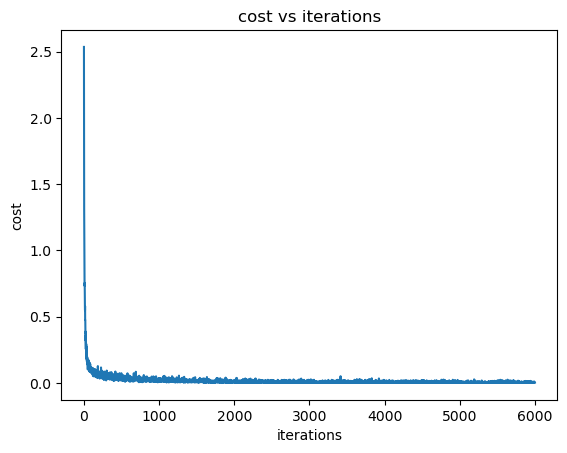

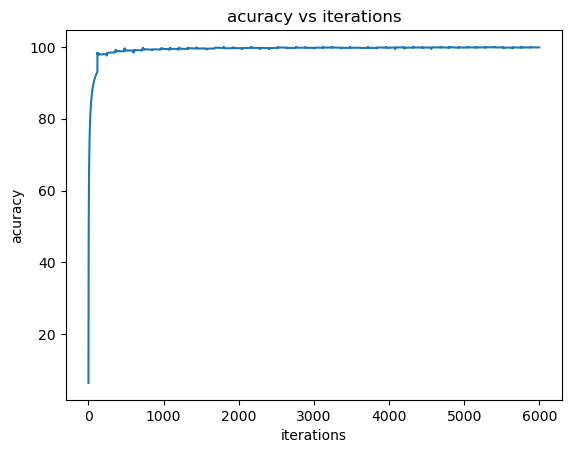

accuracy on the testset:99.11


In [12]:
import matplotlib.pyplot as plt
plt.plot(costs)
plt.xlabel("iterations")
plt.ylabel("cost")
plt.title("cost vs iterations")
plt.show()

plt.plot(acuracies)
plt.xlabel("iterations")
plt.ylabel("acuracy")
plt.title("acuracy vs iterations")
plt.show()
#function for the evaluating the model on the testset
def test():
  model.eval()
  correct=0
  with torch.no_grad():
    for data,target in loader["test"]:
      data,target=data.to(device),target.to(device)
      output=model(data)
      pred=output.argmax(dim=1,keepdim=True)  
      correct+=pred.eq(target.view_as(pred)).sum().item()
  print(f"accuracy on the testset:{(correct/len(loader['test'].dataset))*100}")

test()